In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

In [3]:
df = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_normal_coding_gene_fpkm.txt",sep='\t',index_col=0)
df.columns = [x + '.1' for x in df.columns]
df.to_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/LIHC_normal_coding_gene_fpkm.txt",sep='\t')

In [3]:
path = '/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/'
lihc_df = pd.read_csv(path + 'lihc_coding_gene_exp_profile_normal_only.txt',sep = '\t',index_col = 0)
###standardization 
X = lihc_df.T.to_numpy()
scaler = StandardScaler().fit(X)
lihc_df_stand = scaler.transform(X)
hbv_conversion_table = pd.read_csv(path + 'hbv_gene_conversion_table.txt',sep = '\t',index_col=0)
ens_id = hbv_conversion_table['Ensembl_ID'].values  
sample_df = pd.DataFrame({'Sample' : [x.split('.')[0] for x in lihc_df.columns],'Label' : ['Tumor'] * lihc_df.shape[1]})
idx = [bool(re.search('\.',x)) for x in lihc_df.columns]
sample_df.loc[idx,"Label"] = 'Normal'

FileNotFoundError: [Errno 2] No such file or directory: '/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/lihc_coding_gene_exp_profile_normal_only.txt'

In [4]:
clinical_info_file = 'nationwidechildrens.org_clinical_patient_lihc.txt'
clinical_info = pd.read_csv(path + clinical_info_file,sep='\t')
clinical_info = clinical_info.drop([0,1],axis=0)
idx = [x.split('-')[-1] for x in clinical_info['bcr_patient_barcode']]
clinical_info.index = idx

idx = [bool(re.search('Hepatitis B Surface Antigen' ,x )) for x in clinical_info.loc[:,'viral_hepatitis_serology'].values]
hbv_positive = clinical_info.loc[idx,'viral_hepatitis_serology'].index
tmp = []
for x in sample_df['Sample'] :
    if x in hbv_positive :
        tmp.append('Positive')
    else :
        tmp.append('Negative')
sample_df['HBV'] = tmp
hbv_idx = sample_df[sample_df['HBV'] == 'Positive'].index

### ensemble result

In [11]:
#r_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
train_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/'
result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/'
exp_profile = pd.read_csv(train_path + 'lihc_protein_coding_gene_std_exp_profile_with_synthetic_normal_only.txt',sep = '\t',index_col=0)

In [6]:
def ensemble_result(result_path,prefix,threshold,ratio,binary_flag = False) :

    file_name = result_path + prefix + '_vote_np_ratio_'+str(ratio)+ '.npy'
    p_r = np.load(file_name)
    #transform vote number to binary 0/1
    if binary_flag :
        positive_idx = p_r >= threshold 
        p_r[positive_idx] = 1
        p_r[~positive_idx] = 0

    return p_r

In [14]:
vote = ensemble_result(result_path +"normal_only/" ,"normal_only",threshold=0,ratio=25,binary_flag=False)
gene_idx = [bool(re.search("Synthetic",x)) == False for x in exp_profile.index]
df = pd.DataFrame({"Gene" : list(exp_profile.index[gene_idx]),'Vote' : vote[gene_idx]})
df.to_csv("lihc_ensemble_learning_gene_vote.txt",sep='\t',index=None)

,Gene,Vote
0,ENSG00000069849,0.0
1,ENSG00000131746,0.0
2,ENSG00000141027,0.0
3,ENSG00000164587,0.0
4,ENSG00000122417,0.0
...,...,...
19562,ENSG00000152689,0.0
19563,ENSG00000161677,0.0
19564,ENSG00000139192,29.0
19565,ENSG00000131480,0.0


In [20]:
def metric_performance(prefix,path,metric,title,output_path,hallmark=False) :
    
    metric_median = np.zeros(10)
    metric_std = np.zeros(10)
    for idx,r in enumerate(np.arange(5,55,5)) :
        if hallmark :
            tet = np.load(path + prefix + '_' + metric + '_hallmark_np_ratio_'+str(r)+ '.npy',allow_pickle=True)
        else :
            tet = np.load(path + prefix + '_' + metric + '_np_ratio_'+str(r)+ '.npy',allow_pickle=True)
        metric_median[idx] = round(np.median(tet),3)
        metric_std[idx] = round(np.std(tet),3)

    overall_metric_median = np.zeros(10)
    overall_metric_std = np.zeros(10)
    for idx,r in enumerate(np.arange(5,55,5)) :
        if hallmark :
            tet = np.load(path + prefix + '_' + metric + '_overall_hallmark_np_ratio_'+str(r)+ '.npy',allow_pickle=True)
        else :
            tet = np.load(path + prefix + '_' + metric + '_overall_np_ratio_'+str(r)+ '.npy',allow_pickle=True)
        overall_metric_median[idx] = round(np.median(tet),3)
        overall_metric_std[idx] = round(np.std(tet),3)


    plt.figure(figsize=(10,5))
    plt.errorbar(np.arange(5,55,5),metric_median,yerr = metric_std,marker = '*', label=metric.capitalize(),color = "darksalmon",ms = 10)
    plt.errorbar(np.arange(5,55,5),overall_metric_median,yerr = overall_metric_std, marker = '*',label='Overall ' +metric ,color = "mediumaquamarine",ms = 10)
    plt.ylabel(metric.capitalize())
    plt.xlabel('N/P ratio')
    plt.legend()
    plt.title(title)
    plt.savefig(output_path,dpi=300)

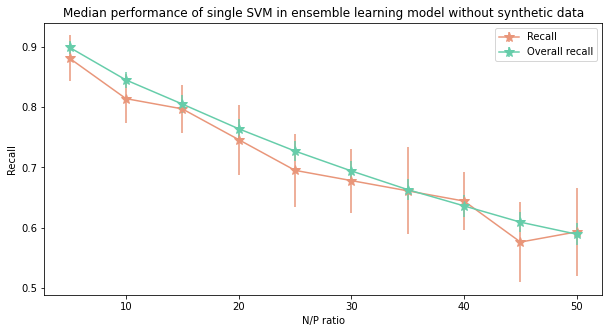

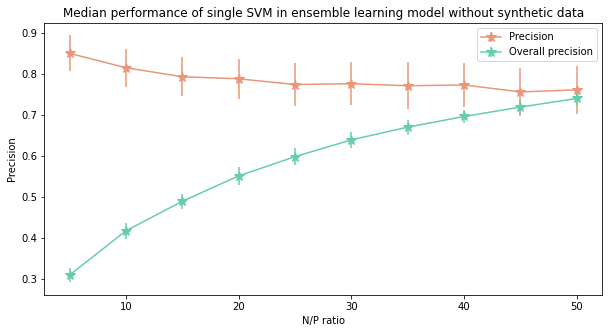

In [21]:
i = 1
metric = ['recall','precision']
title = "Median performance of single SVM in ensemble learning model without synthetic data" 
for m in metric :
    output_p = 'hallmark.png'
    metric_performance('normal_only',result_path + 'normal_only/',m,title,output_p,hallmark=True)

### legacy

In [8]:
from sklearn.metrics import roc_auc_score,recall_score,precision_score

def grid_search_of_ensemble_vote_threshold(r_path,prefix,y,threshold,np_ratio):
    
    shape = (len(np_ratio),len(threshold))
    auc = np.zeros(shape)
    recall = np.zeros(shape)
    precision = np.zeros(shape)
    n_pos = np.zeros(shape,dtype=int)

    for r_idx,r in enumerate(np_ratio) :
        for t_idx,t in enumerate(threshold) :
            y_pred = ensemble_result(r_path,prefix,t,r,binary_flag=True)
            n_pos[r_idx,t_idx] = int(sum(y_pred))
            auc[r_idx,t_idx] = roc_auc_score(y,y_pred)
            recall[r_idx,t_idx] =  recall_score(y,y_pred,pos_label=1)
            precision[r_idx,t_idx] =  precision_score(y,y_pred,pos_label=1)

    return auc,recall,precision,n_pos

def grid_search_for_ensemble_np(r_path,prefix,y,threshold,np_ratio) :

    #auc = np.zeros(len(np_ratio))
    recall = np.zeros(len(np_ratio))
    precision = np.zeros(len(np_ratio))
    n_pos = np.zeros(len(np_ratio))
    l = np.zeros(len(np_ratio))

    for idx,r in enumerate(np_ratio) :
        y_pred = ensemble_result(r_path,prefix,threshold,r,binary_flag=True)
        #auc[idx] = roc_auc_score(y,y_pred)
        recall[idx] =  recall_score(y,y_pred)
        precision[idx] =  precision_score(y,y_pred)
        n_pos[idx] = int(sum(y_pred))
        l[idx] = int(r)

    l = list(l)
    return l,recall,precision,n_pos

In [9]:
def twinx_metric_plot(ax,y,np_r,th,r_path,prefix) :

    a,r,p,n = grid_search_of_ensemble_vote_threshold(r_path,prefix,y,th,[np_r])
    ax2 = ax.twinx()

    c1, = ax.plot(th,p[0], '--o', label='Precision',color = "darksalmon")
    c2, = ax.plot(th,r[0],'--o',label = 'Recall',color = 'mediumaquamarine')
    c3, = ax2.plot(th,n[0],'--o',label = 'Number of positive',color = 'dodgerblue')

    ax.set_xlabel('threshold')
    ax.set_title('N/P ratio : '+str(np_r))
    ax.set_ylabel('Metric')
    ax2.set_ylabel('Number of positive')
    #ax.legend(loc='lower right')

    curves = [c1,c2,c3]
    ax.legend(curves, [curve.get_label() for curve in curves])
    ax.set_xticks(th)
    ax.set_xticklabels(th,rotation = 90)

    return ax, ax2

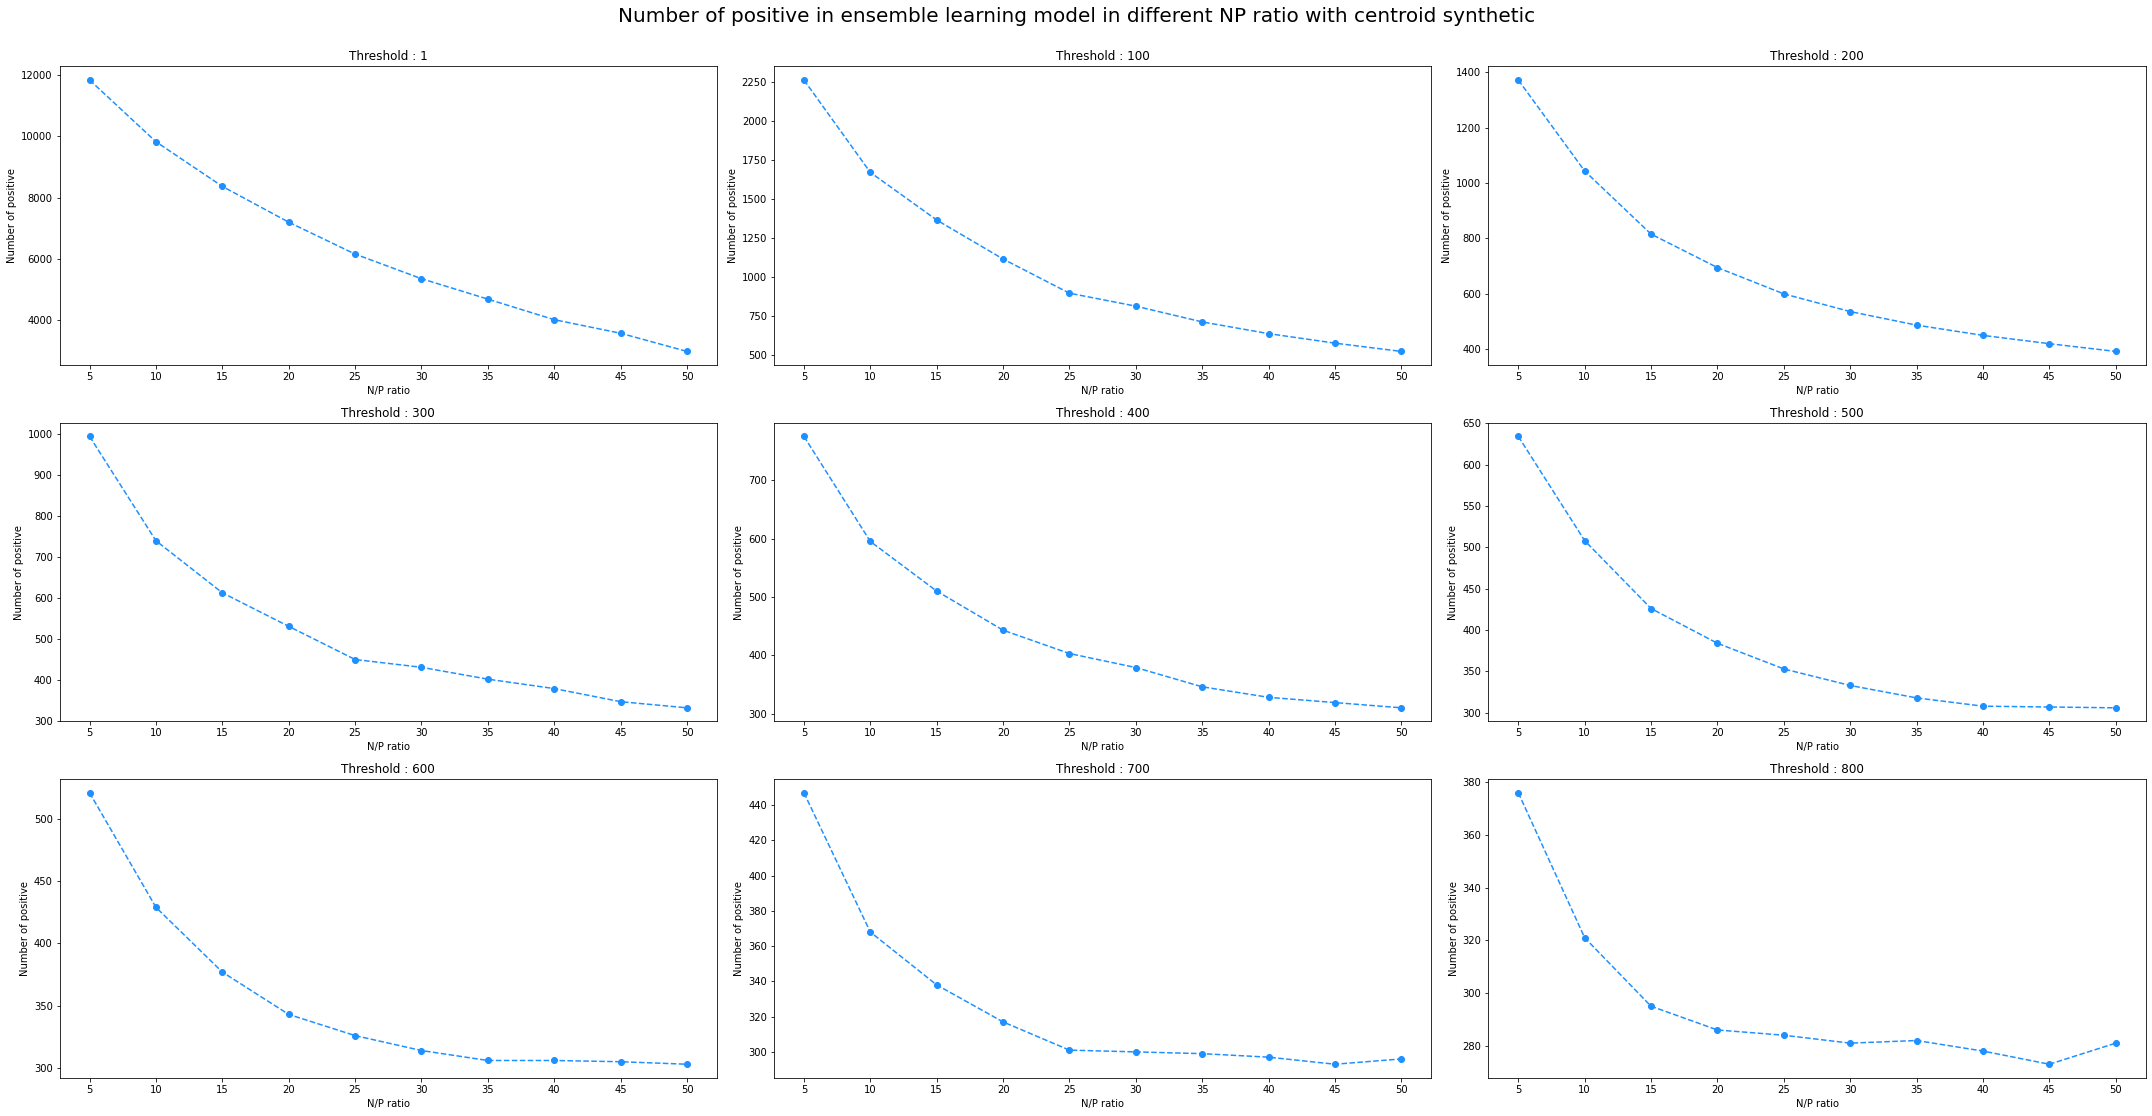

In [10]:
y = np.zeros(centroid_with_synthetic_df.shape[0])
pos_id = list(ens_id)
for x in range(206) :
    k = 'Centroid' + str(x) 
    pos_id.append(k)

pos_idx = [x in pos_id for x in centroid_with_synthetic_df.index]
y[pos_idx] = 1

np_r = np.arange(5,55,5)
th = np.arange(0,1000,100)
th[0] = 1
np_r = np.arange(5,55,5)

fig, axs = plt.subplots(3,3, figsize=(30,15))
axes = axs.ravel()
for idx,ax in enumerate(axes) :
    t = th[idx]
    a,r,p,n = grid_search_of_ensemble_vote_threshold(path_l[0],prefix_l[0],y,[t],np_r)
    ax.plot(np_r,n, '--o', label='Number of positive',color = "dodgerblue")
    ax.set_xlabel('N/P ratio')
    ax.set_ylabel('Number of positive')
    ax.set_title('Threshold : ' + str(t))
    ax.set_xticks(np_r)
    ax.set_xticklabels(np_r)
plt.tight_layout()
plt.suptitle('Number of positive in ensemble learning model in different NP ratio with centroid synthetic',fontsize = 20,y=1.03)
plt.savefig(output_path + 'n_pos_of_ensemble_learning_model_centroid.png',bbox_inches = 'tight')

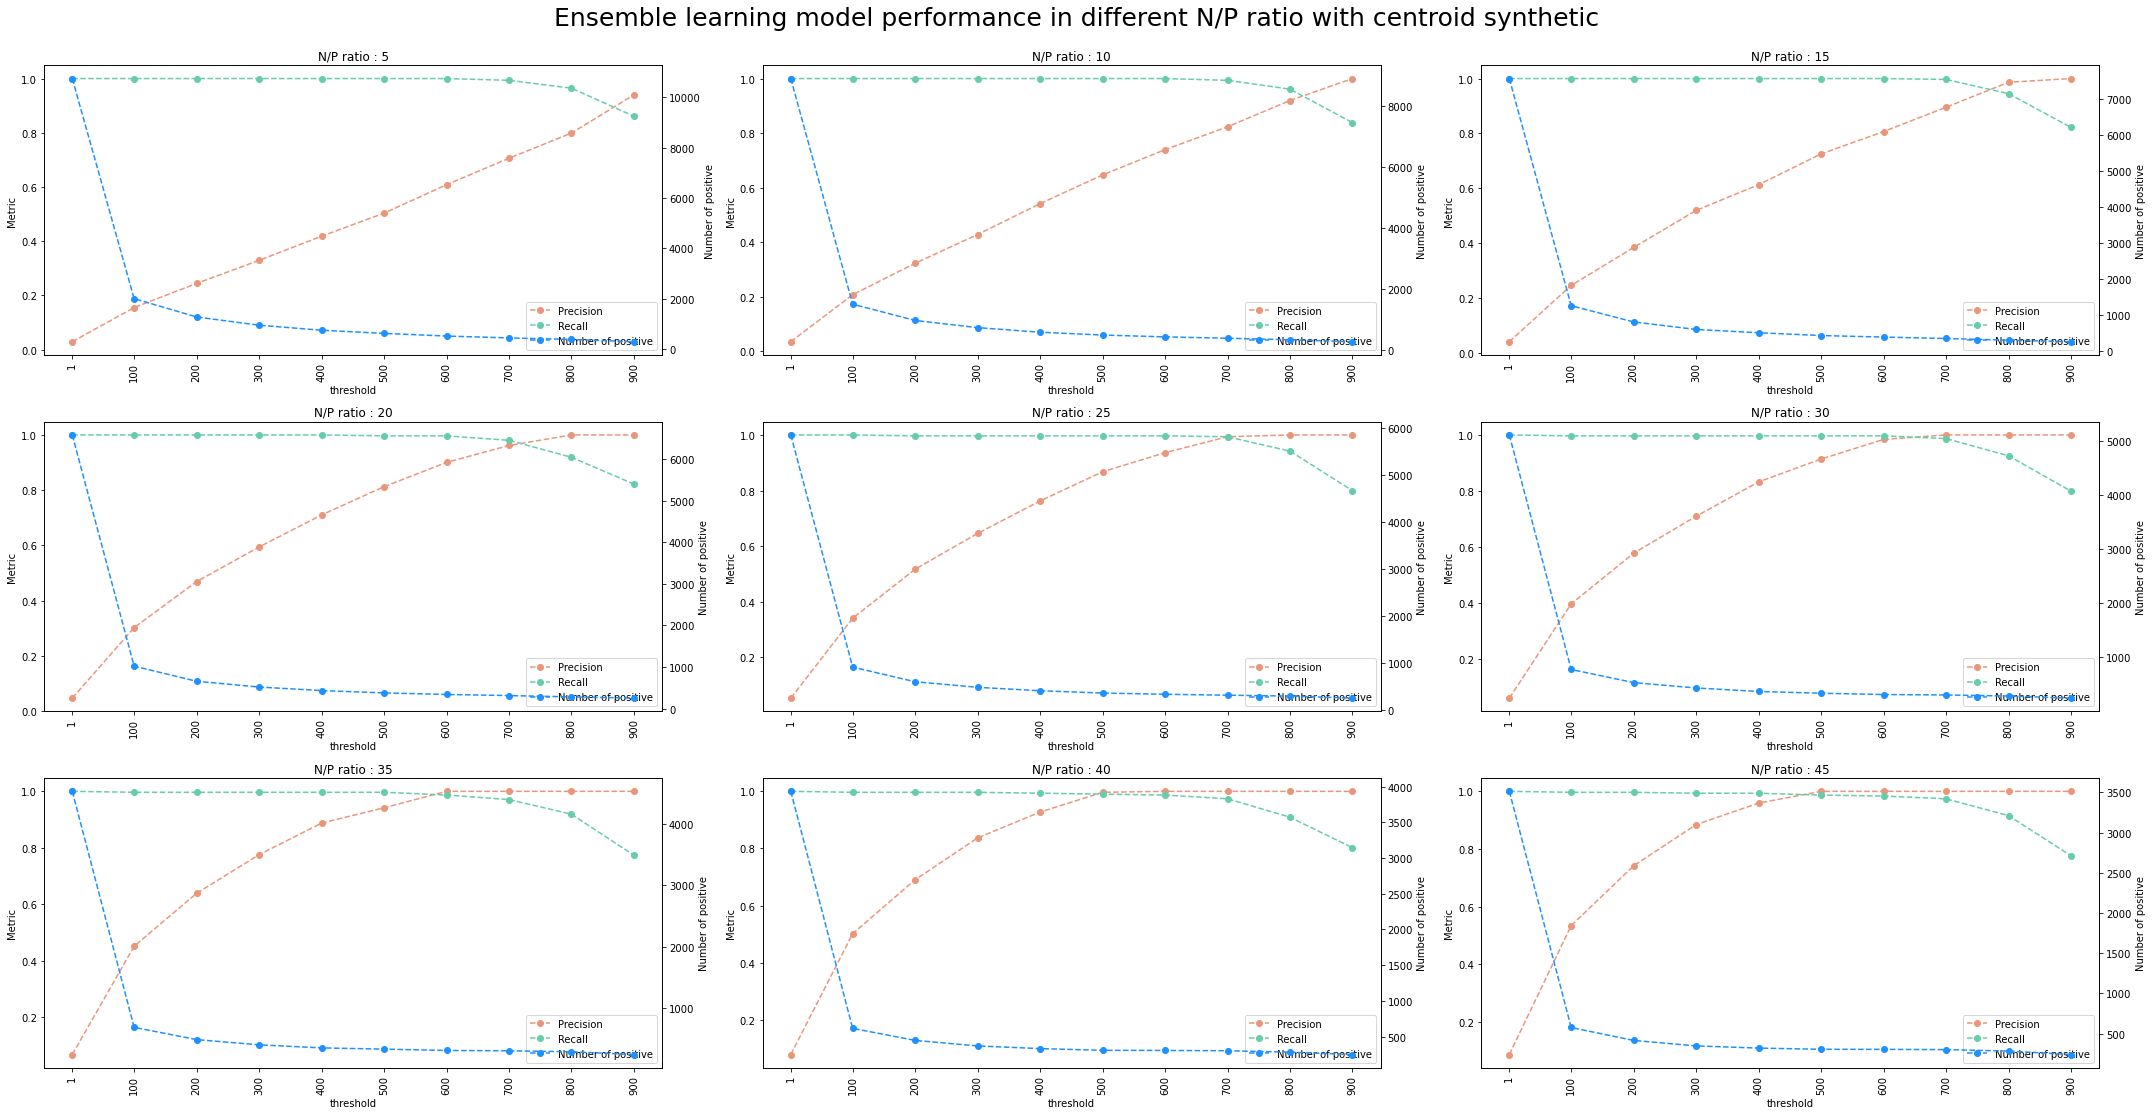

In [26]:
y = np.zeros(centroid_with_synthetic_df.shape[0])
pos_id = list(ens_id)
for x in range(206) :
    k = 'Centroid' + str(x) 
    pos_id.append(k)

pos_idx = [x in pos_id for x in centroid_with_synthetic_df.index]
y[pos_idx] = 1

th = np.arange(0,1000,100)
th[0] = 1
np_r = np.arange(5,55,5)

fig, axs = plt.subplots(3,3, figsize=(30,15))
axes = axs.ravel()
for idx,ax in enumerate(axes) :
    r = np_r[idx]
    twinx_metric_plot(ax,y,r,th,path_l[0],prefix_l[0])
plt.tight_layout()
plt.suptitle('Ensemble learning model performance in different N/P ratio with centroid synthetic',fontsize = 25,y=1.03)
plt.savefig(output_path + 'ensemble_model_performance_centroid.png')

### Candidate gene

select candidate gene by ensemble result of following parameter : <br>
vote threshold : 100-1000<br>
N/P ratio : 5

### selected threshold cut-off by HBV classification performance

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA,KernelPCA
from sklearn.metrics import recall_score
#import xgboost as xgb

In [8]:
y = np.zeros(centroid_with_synthetic_df.shape[0])
pos_id = list(ens_id)
for x in range(206) :
    k = 'Centroid' + str(x) 
    pos_id.append(k)

### find the cutoff point of number of positive/vote threshold curve

In [33]:
from sklearn.metrics import recall_score

def candidate_hallmark_recall(hallmark_gene,result_prefix,result_path,np_ratio,fig_output) :
    
    threshold = np.arange(1,1001)
    pos_num = np.zeros(len(threshold))
    ens_vote_matrix = np.zeros((len(hallmark_gene),len(threshold)))
    ens_idx = [x in hallmark_gene for x in exp_profile.index]
    no_synthetic_idx = [bool(re.search('Synthetic',x)) == False for x in exp_profile.index]

    for idx,t in enumerate(threshold) :
        y_pred = ensemble_result(result_path,result_prefix,t,np_ratio,binary_flag=True)
        ens_vote_matrix[:,idx] = y_pred[ens_idx] 
        pos_num[idx] = sum(y_pred[no_synthetic_idx])

    ens_pos_num = ens_vote_matrix.sum(axis=0)
    ens_ratio = ens_pos_num / pos_num

    ens_recall = np.zeros(len(threshold))
    ens_y = np.repeat(1,len(hallmark_gene))
    for i in range(len(threshold)) :
        ens_pred = ens_vote_matrix[:,i]
        ens_recall[i] = recall_score(ens_y,ens_pred)
        
    ###plot
    fig,ax1 = plt.subplots(figsize = (8,5))
    ax2 = plt.twinx(ax1)
    c1 = ax1.errorbar(threshold,ens_ratio,label = 'Hallmark ratio in candidate gene',color = 'darksalmon')
    c2 = ax1.errorbar(threshold,ens_recall,label = 'Hallmark recall',color = "aquamarine")
    ax1.set_ylabel("Metric")
    c3 = ax2.errorbar(threshold,pos_num,label = 'Number of positive',color = '#33CCFF')
    ax2.set_ylabel("Number of positive")

    curves = [c1,c2,c3]
    ax1.legend(curves,['Hallmark ratio in candidate gene','Hallmark recall','Number of positive'],loc = 'center left')
    plt.xlabel("Vote threshold")
    plt.title("Hallmark gene racall & ratio in candidate gene")
    plt.savefig(fig_output,dpi = 300)

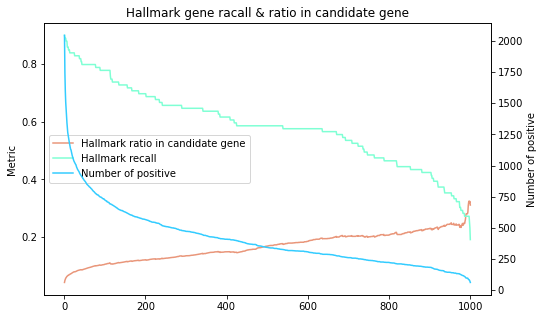

In [38]:
# load hallmark gene ens id
hallmark = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/hallmark_gene/hallmark_protein_coding_ens_id.txt",sep='\t')
hallmark.columns = ["EnsID"]  # type: ignore
hallmark_gene = hallmark['EnsID'].values

result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/' + 'normal_only/'
candidate_hallmark_recall(hallmark_gene,'normal_only',result_path,10,'test.png')

In [48]:
def candidate_gene_proportion(hallmark_gene,exp_profile,result_path,result_prefix,np_ratio,fig_output,vote_floor=1000) :
    
    threshold = np.arange(1,vote_floor+1)
    pos_num = np.zeros(len(threshold))
    ens_pos = np.zeros(len(threshold))
    syn_pos = np.zeros(len(threshold))
    ens_idx = [x in hallmark_gene for x in exp_profile.index]
    synthetic_idx = [bool(re.search('Synthetic',x)) for x in exp_profile.index]

    for idx,t in enumerate(threshold) :
        y_pred = ensemble_result(result_path,result_prefix,t,np_ratio,binary_flag=True)
        pos_num[idx] = sum(y_pred)
        ens_pos[idx] = sum(y_pred[ens_idx])
        syn_pos[idx] = sum(y_pred[synthetic_idx])

    residual_pos = (pos_num - ens_pos - syn_pos) / pos_num
    ens_pos = ens_pos/ pos_num
    syn_pos = syn_pos / pos_num

    df = pd.DataFrame({'Hallmark positive' : ens_pos,'Synthetic positive' : syn_pos,'Residual' : residual_pos})
    
    df.columns = ['Hallmark','Synthetic','Candidate']  # type: ignore
    df.plot(kind = 'bar',stacked = True,figsize = (12,5))
    plt.xticks(np.arange(0,vote_floor,100))
    plt.xlabel("Vote threshold",fontsize = 12)
    plt.ylabel("Ratio",fontsize =12)
    plt.title("Gene vote above threhold proportion")
    plt.legend(loc = 'center right')
    plt.savefig(fig_output,dpi = 300)

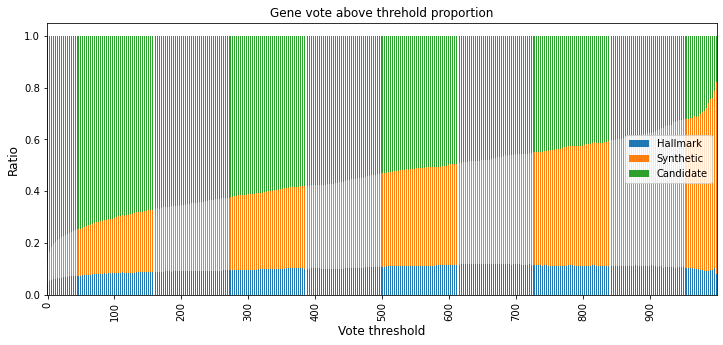

In [49]:
result_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/' + 'normal_only/'
candidate_gene_proportion(hallmark_gene,exp_profile,result_path,'normal_only',10,'test.png')

In [39]:
threshold = np.arange(1,1001)
pos_num = np.zeros(len(threshold))
ens_pos = np.zeros(len(threshold))
syn_pos = np.zeros(len(threshold))
ens_idx = [x in hallmark_gene for x in exp_profile.index]
synthetic_idx = [bool(re.search('Synthetic',x)) for x in exp_profile.index]

for idx,t in enumerate(threshold) :
    y_pred = ensemble_result(result_path,'normal_only',t,10,binary_flag=True)
    pos_num[idx] = sum(y_pred)
    ens_pos[idx] = sum(y_pred[ens_idx])
    syn_pos[idx] = sum(y_pred[synthetic_idx])

residual_pos = (pos_num - ens_pos - syn_pos) / pos_num
ens_pos = ens_pos/ pos_num
syn_pos = syn_pos / pos_num

df = pd.DataFrame({'Hallmark positive' : ens_pos,'Synthetic positive' : syn_pos,'Residual' : residual_pos})

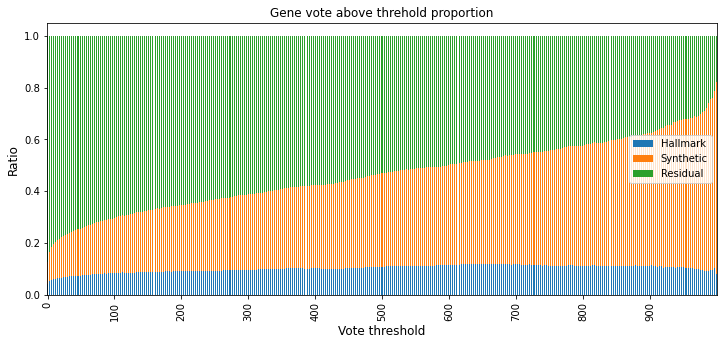

In [47]:
df.columns = ['Hallmark','Synthetic','Residual']
df.plot(kind = 'bar',stacked = True,figsize = (12,5))
plt.xticks(np.arange(0,1000,100))
plt.xlabel("Vote threshold",fontsize = 12)
plt.ylabel("Ratio",fontsize =12)
plt.title("Gene vote above threhold proportion")
plt.legend(loc = 'center right')
plt.savefig('Vote_proportion.png',dpi = 300)

In [54]:
from scipy import interpolate
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

def draw_tangent(x,y,a,append):
    # interpolate the data with a spline
    spl = interpolate.splrep(x,y)
    small_t = np.arange(a-append,a+append)
    fa = interpolate.splev(a,spl,der=0)     # f(a)
    fprime = interpolate.splev(a,spl,der=1) # f'(a)
    tan = fa+fprime*(small_t-a) # tangent
    plt.plot(a,fa,'om',small_t,tan,'--r')

def find_cutoff_point(x,y,n_seg,find_nth_seg,output_path) : 
    
    dys = np.gradient(y, x)
    rgr = DecisionTreeRegressor(max_leaf_nodes=n_seg).fit(x.reshape(-1, 1), dys.reshape(-1, 1))
    dys_dt = rgr.predict(x.reshape(-1, 1)).flatten()
    '''
    ys_sl = np.ones(len(x)) * np.nan
    for i in np.unique(dys_dt):
        msk = dys_dt == i
        lin_reg = LinearRegression()
        lin_reg.fit(x[msk].reshape(-1, 1), y[msk].reshape(-1, 1))
        ys_sl[msk] = lin_reg.predict(x[msk].reshape(-1, 1)).flatten()
    '''

    segth = []
    cutoff = []
    count = 0
    for idx,d in enumerate(dys_dt) :
        if d not in segth :
            segth.append(d)
            cutoff.append(x[idx])
    cutoff_p = cutoff[find_nth_seg-1]
    
    plt.figure(figsize = (8,4))
    plt.errorbar(x, y, marker='*', c='#33CCFF', linestyle='--', label ='Number of positive',alpha = 0.5)

    for i in range(len(cutoff)):
        draw_tangent(x,y,cutoff[i],0)
    draw_tangent(x,y,cutoff_p,20)
    y_idx = np.where(x == cutoff_p)[0][0]
    annotation = '(' + str(cutoff_p) + ',' + str(y[y_idx+1]) + ')'
    plt.text(cutoff_p+0.05*len(x),y[y_idx],annotation )
    plt.xlabel("Vote threshold"); 
    plt.ylabel("Number of positive")
    plt.legend()
    plt.title("Number of positive in different vote threshold")
    plt.savefig(output_path)
    return cutoff

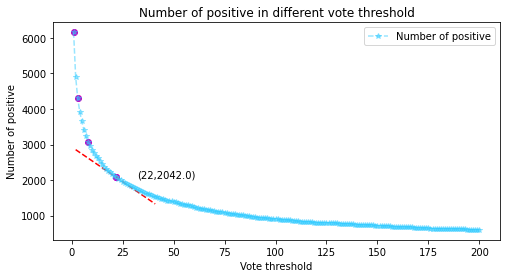

In [57]:
x = threshold[:200]
y = pos_num[:200]

c = find_cutoff_point(x,y,4,4,output_path + "Number_of_positive.png")

In [9]:
ens_idx = [x in ens_id for x in centroid_with_synthetic_df.index]
no_synthetic_idx = [bool(re.search('Centroid',x)) == False for x in centroid_with_synthetic_df.index]

x = ensemble_result(path_l[0],prefix_l[0],0,25,binary_flag=False)
y = np.zeros(len(x))
y[ens_idx] = 1
x = x[no_synthetic_idx]
y = y[no_synthetic_idx]

x = x.reshape(-1,1)
y = y.reshape(-1,1)

In [41]:
def mcc(tn, fp, fn, tp) : 
    value = ((tp*tn) -(fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)) 
    return value

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,average_precision_score,confusion_matrix,f1_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,stratify = y)
lr = LogisticRegression(C=1)
lr.fit(x_train,y_train)
svm = SVC()
svm.fit(x_train,y_train)
lr_pred = lr.predict(x_test)
svm_pred = svm.predict(x_test)

lr_auc = roc_auc_score(y_test,lr_pred)
lr_f1 = f1_score(y_test,lr_pred)
tn, fp, fn, tp = confusion_matrix(y_test, lr_pred).ravel()
lr_mcc = mcc(tn, fp, fn, tp)

svm_auc = roc_auc_score(y_test,svm_pred)
svm_f1 = f1_score(y_test,svm_pred)
tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
svm_mcc = mcc(tn, fp, fn, tp)

/home/bruce1996/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/bruce1996/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


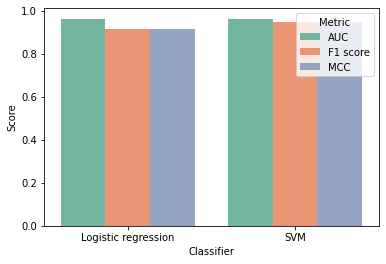

In [51]:
df = pd.DataFrame({'Classifier' : ['Logistic regression']*3+['SVM']*3,'Score' : [lr_auc,lr_f1,lr_mcc,svm_auc,svm_f1,svm_mcc],'Metric' : ['AUC','F1 score','MCC'] *2})
sns.barplot(data=df,x='Classifier',y = 'Score',hue='Metric',palette='Set2')
plt.savefig(output_path + 'mcc.png')

/home/bruce1996/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


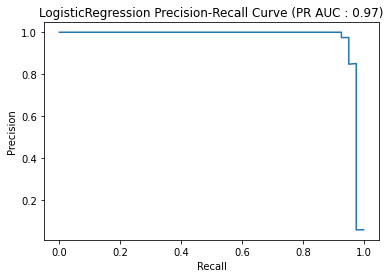

In [22]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,average_precision_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

x = x.reshape(-1,1)
y = y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4,stratify = y)
classifier = LogisticRegression(C=1)
classifier.fit(x_train.reshape(-1,1),y_train.reshape(-1,1))
y_score = classifier.decision_function(x_test)

average_precision = average_precision_score(y_test, y_score)

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig, ax = plt.subplots()
ax.plot(recall, precision)

#add axis labels to plot
ax.set_title('LogisticRegression Precision-Recall Curve' + ' (PR AUC : ' + str(round(average_precision,2)) + ')')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig(output_path + 'lr_prauc.png',dpi = 300)


### model performance for predict HBV of not

In [17]:
np_r = 25
threshold = np.arange(0,800,100)
threshold[0] = 1

auc_dict = {'lr' : [np.zeros(len(threshold)),np.zeros(len(threshold))],
            'svm' : [np.zeros(len(threshold)),np.zeros(len(threshold))],
            'rf' : [np.zeros(len(threshold)),np.zeros(len(threshold))]}

acc_dict = {'lr' : [np.zeros(len(threshold)),np.zeros(len(threshold))],
            'svm' : [np.zeros(len(threshold)),np.zeros(len(threshold))],
            'rf' : [np.zeros(len(threshold)),np.zeros(len(threshold))]}

number_candidate = np.zeros(len(threshold))

------------------threshold : 1------------------
------------------threshold : 100------------------
------------------threshold : 200------------------
------------------threshold : 300------------------
------------------threshold : 400------------------
------------------threshold : 500------------------
------------------threshold : 600------------------
------------------threshold : 700------------------


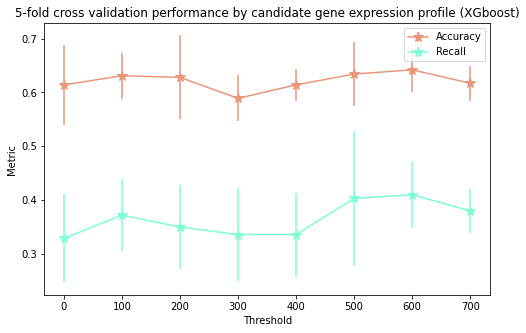

In [26]:
acc_array = np.zeros(len(threshold))
acc_err = np.zeros(len(threshold))
recall_array = np.zeros(len(threshold))
recall_err = np.zeros(len(threshold))

for idx,t in enumerate(threshold) :
    y_pred = ensemble_result(path_l[0],prefix_l[0],t,np_r,binary_flag=True)
    pos_idx = y_pred > 0
    pos_gene = list(exp_profile.index[pos_idx])
    candidate_gene = [item for item in pos_gene if item not in pos_id]
    number_candidate[idx] = len(candidate_gene)
    candidate_df = exp_profile.loc[pos_gene,:]
    print('------------------threshold : %d------------------' % t)
    X = candidate_df.T.to_numpy()
    Y = np.where(metadata['HBV'] == 'Positive',1,0)

    xgbmodel = xgb.XGBClassifier(n_estimators=1000,n_jobs = 32,max_depth = 10,eval_metric='logloss',use_label_encoder=False)
    acc = cross_val_score(xgbmodel, X, Y, cv=5, scoring='accuracy')
    r = cross_val_score(xgbmodel, X, Y, cv=5, scoring='recall')
    '''
    print("XGB accuracy : ", round(np.mean(acc),3), " +- ", round(np.std(acc),3))
    print("XGB recall : ", round(np.mean(r),3), " +- ", round(np.std(r),3))
    '''
    acc_array[idx] = round(np.mean(acc),3)
    acc_err[idx] = round(np.std(acc),3)
    recall_array[idx] = round(np.mean(r),3)
    recall_err[idx] = round(np.std(r),3)

plt.figure(figsize=(8,5))
plt.errorbar(threshold,acc_array,yerr=acc_err,marker = '*', label='Accuracy',color = "darksalmon",ms = 10)
plt.errorbar(threshold,recall_array,yerr=recall_err,marker = '*', label='Recall',color = "aquamarine",ms = 10)
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.title('5-fold cross validation performance by candidate gene expression profile (XGboost)')
plt.legend()
plt.savefig(output_path + 'xgb_5dold_cv.png',dpi = 300)


In [ ]:
for idx,t in enumerate(threshold) :
    y_pred = ensemble_result(path_l[0],prefix_l[0],t,np_r,binary_flag=True)
    pos_idx = y_pred > 0
    pos_gene = list(exp_profile.index[pos_idx])
    candidate_gene = [item for item in pos_gene if item not in pos_id]
    number_candidate[idx] = len(candidate_gene)
    candidate_df = exp_profile.loc[pos_gene,:]
    print('------------------threshold : %d------------------' % t)

    X = candidate_df.T.to_numpy()
    Y = np.where(metadata['HBV'] == 'Positive',1,0)
    lrf = LogisticRegression(C = 1,solver='lbfgs')
    clf = svm.SVC(kernel='rbf', probability = True)
    rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=4,min_samples_split=3)
    # 5 fold CV ROC-AUC
    auc = cross_val_score(lrf, X, Y, cv=5, scoring='roc_auc')
    auc_dict['lr'][0][idx] = round(np.mean(auc),3)
    auc_dict['lr'][1][idx] = round(np.std(auc),3)
    acc = cross_val_score(lrf, X, Y, cv=5, scoring='accuracy')
    acc_dict['lr'][0][idx] = round(np.mean(auc),3)
    acc_dict['lr'][1][idx] = round(np.std(auc),3)
    print("LR : ", round(np.mean(auc),3), " +- ", round(np.std(auc),3))
    #svm 
    auc = cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
    auc_dict['svm'][0][idx] = round(np.mean(auc),3)
    auc_dict['svm'][1][idx] = round(np.std(auc),3)
    acc = cross_val_score(lrf, X, Y, cv=5, scoring='accuracy')
    acc_dict['svm'][0][idx] = round(np.mean(auc),3)
    acc_dict['svm'][1][idx] = round(np.std(auc),3)
    print("SVM : ", round(np.mean(auc),3), " +- ", round(np.std(auc),3))
    #rf
    auc = cross_val_score(rf, X, Y, cv=5, scoring='roc_auc')
    auc_dict['rf'][0][idx] = round(np.mean(auc),3)
    auc_dict['rf'][1][idx] = round(np.std(auc),3)
    acc = cross_val_score(lrf, X, Y, cv=5, scoring='accuracy')
    acc_dict['rf'][0][idx] = round(np.mean(auc),3)
    acc_dict['rf'][1][idx] = round(np.std(auc),3)
    print("RF  : ", round(np.mean(auc),3), " +- ", round(np.std(auc),3))

In [16]:
def performance_metric_plot(performance_dict,n_feature,threshold,metric,title,output_path) :

    fig, ax1 = plt.subplots(figsize=(8,5))
    ax2 = ax1.twinx()

    c1 = ax1.errorbar(threshold,performance_dict['lr'][0],yerr = performance_dict['lr'][1],marker = '*', label='Logistic regression',color = "darksalmon",ms = 10)
    c2 = ax1.errorbar(threshold,performance_dict['svm'][0],yerr = performance_dict['svm'][1],marker = '*', label='SVM',color = "aquamarine",ms = 10)
    c3 = ax1.errorbar(threshold,performance_dict['rf'][0],yerr = performance_dict['rf'][1],marker = '*', label='Random forest',color = "dodgerblue",ms = 10)
    c4 = ax2.errorbar(threshold,n_feature,marker = 'o',label = 'Number of positive',color = 'orange')

    curves = [c1,c2,c3,c4]
    ax1.legend(curves,['Logistic regression','SVM','Random forest','Number of positive'])
    ax1.set_xticks(threshold)
    
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel(metric)
    ax2.set_ylabel('Number of candidate')
    #plt.title('5-fold cross validation performance by candidate gene expression profile')
    plt.title(title)
    plt.savefig(output_path,dpi = 300)

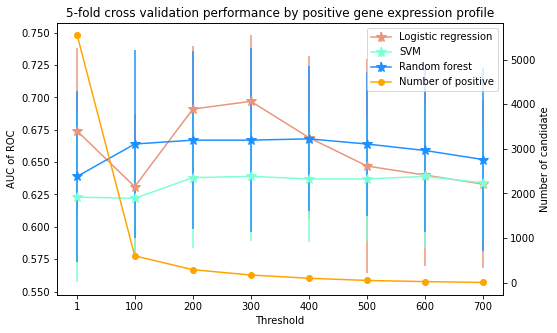

In [17]:
performance_metric_plot(auc_dict,number_candidate,threshold,'AUC of ROC','5-fold cross validation performance by positive gene expression profile',output_path + '5_fold_cv_of_auc_pos__tumor_only_exp_profile.png')

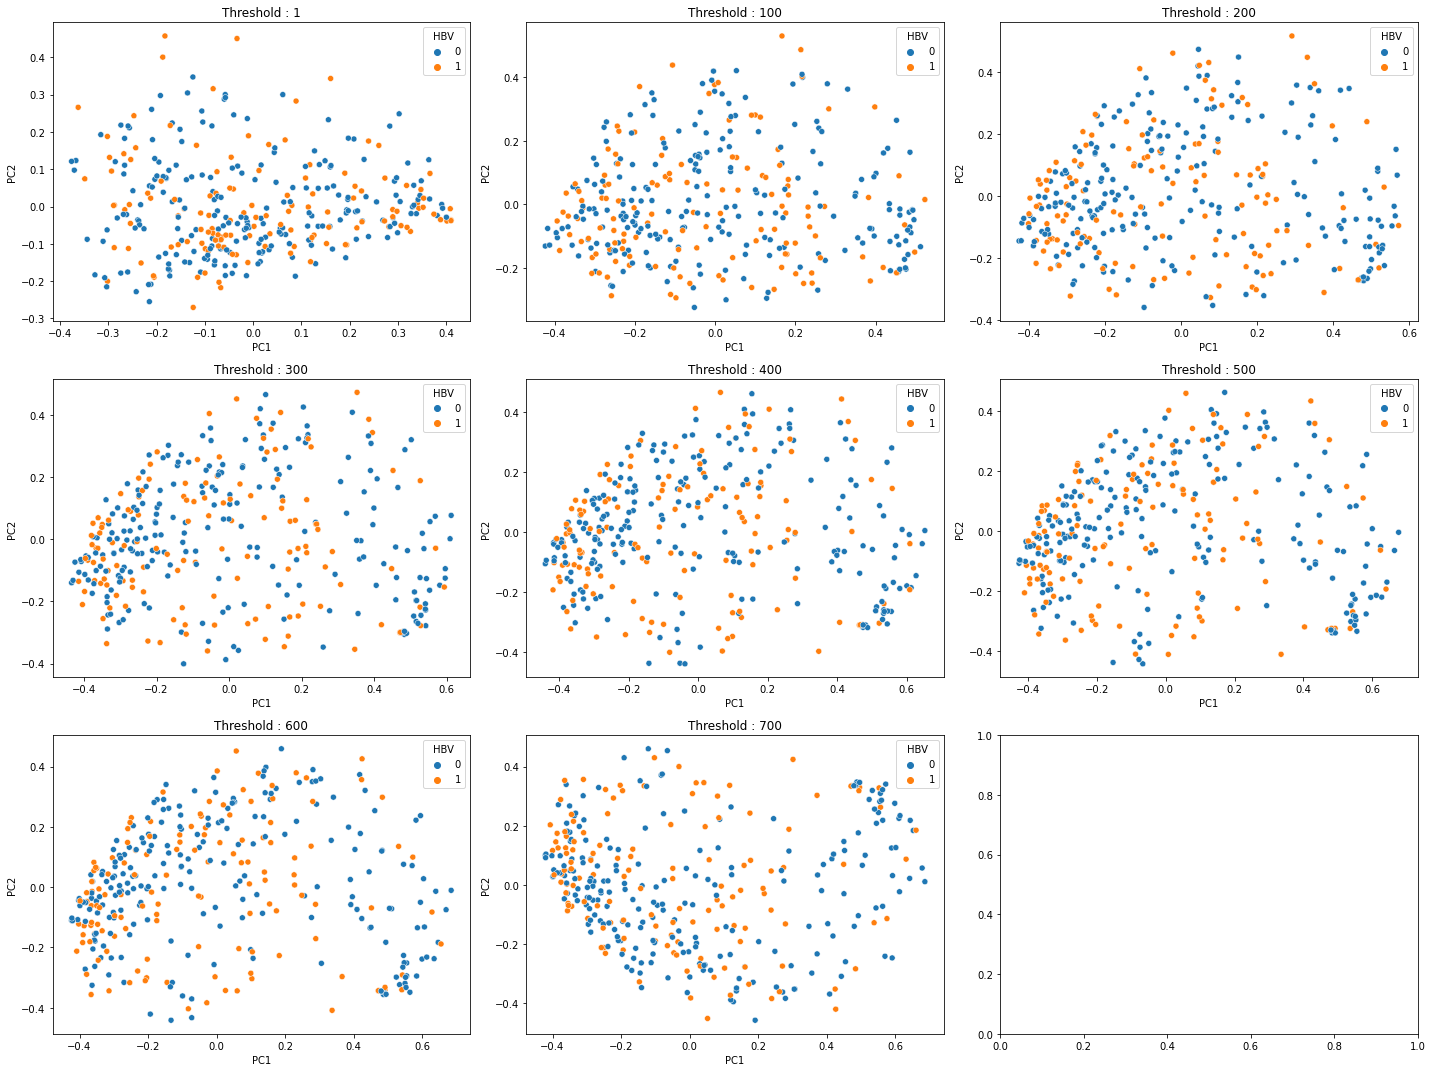

In [120]:
fig, axs = plt.subplots(3,3, figsize=(20,15))
axes = axs.ravel()
for idx,ax in enumerate(axes) :
    if idx > 7 :
        pass
    else :
        t = threshold[idx]
        y_pred = ensemble_result(path_l[0],prefix_l[0],t,np_r,binary_flag=True)
        pos_idx = y_pred > 0
        pos_gene = list(exp_profile.index[pos_idx])
        candidate_gene = [item for item in pos_gene if item not in pos_id]
        number_candidate[idx] = len(candidate_gene)
        candidate_df = exp_profile.loc[pos_gene,:]

        X = candidate_df.T.to_numpy()
        Y = np.where(metadata['HBV'] == 'Positive',1,0)
        pca = KernelPCA(n_components=2,kernel='rbf')
        candidate_pca = pca.fit_transform(X)
        plot_df = pd.DataFrame({'PC1' : candidate_pca[:,0],'PC2' : candidate_pca[:,1],'HBV' : Y})

        sns.scatterplot(data=plot_df,x='PC1',y='PC2',hue='HBV',ax=ax)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title('Threshold : ' + str(t))
plt.tight_layout()
plt.savefig(output_path + 'rbf_pca_of_positive_diff_threshold.png')

### model performance in valided dataset

In [ ]:
valid_data = pd.DataFrame()

valid_path = '/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/GSE77509_RAW/'
files = os.listdir(valid_path)
file_name = []
for f in files :
    print(f)
    if bool(re.search('_N',f)) :
        pass
    else :
        name = f.split('.')[0]
        print(name)
        exp_file = pd.read_csv(valid_path + f,sep='\t',index_col=0)
        exp_file.columns = [name]        
        valid_data = pd.concat([valid_data,exp_file],axis=1)

In [150]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = valid_data.T.to_numpy()
x = scaler.fit_transform(X)
valid_std = pd.DataFrame(x.T,index=valid_data.index,columns=valid_data.columns)
valid_y = [bool(re.search('_P',x)) for x in valid_data.columns]

In [152]:
valid_ens_id = list(set(valid_std.index).intersection(ens_id))
hallmark_valid = valid_std.loc[valid_ens_id,:]

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

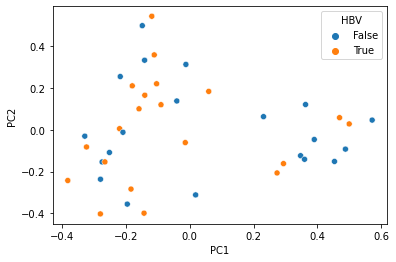

In [157]:
X = hallmark_valid.T.to_numpy()
pca = KernelPCA(n_components=2,kernel='rbf')
hallmark_pca = pca.fit_transform(X)
plot_df = pd.DataFrame({'PC1' : hallmark_pca[:,0],'PC2' : hallmark_pca[:,1],'HBV' : valid_y})
sns.scatterplot(data=plot_df,x='PC1',y='PC2',hue='HBV')
plt.title('Kernel PCA of Validation datset (GSE)')

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(20,15))
axes = axs.ravel()
for idx,ax in enumerate(axes) :
    if idx > 7 :
        pass
    else :
        t = threshold[idx]
        y_pred = ensemble_result(path_l[0],prefix_l[0],t,np_r,binary_flag=True)
        pos_idx = y_pred > 0
        pos_gene = list(exp_profile.index[pos_idx])
        candidate_gene = [item for item in pos_gene if item not in pos_id]
        number_candidate[idx] = len(candidate_gene)
        candidate_df = exp_profile.loc[pos_gene,:]

        X = candidate_df.T.to_numpy()
        Y = np.where(metadata['HBV'] == 'Positive',1,0)
        pca = KernelPCA(n_components=2,kernel='rbf')
        candidate_pca = pca.fit_transform(X)
        plot_df = pd.DataFrame({'PC1' : candidate_pca[:,0],'PC2' : candidate_pca[:,1],'HBV' : Y})

        sns.scatterplot(data=plot_df,x='PC1',y='PC2',hue='HBV',ax=ax)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title('Threshold : ' + str(t))
plt.tight_layout()
plt.savefig(output_path + 'valid_rbf_pca_of_positive_diff_threshold.png')

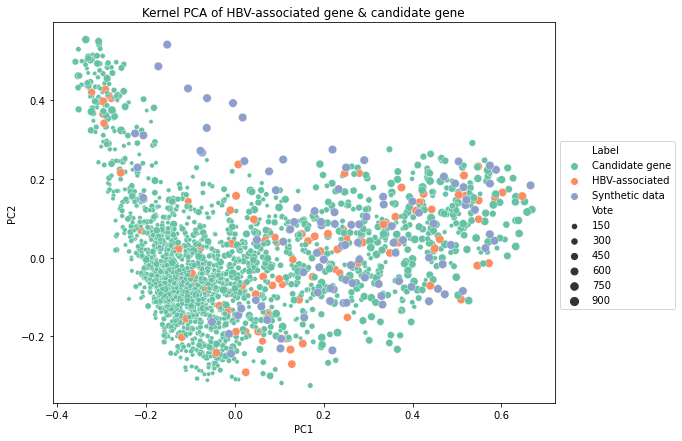

In [127]:
from sklearn.decomposition import PCA,KernelPCA

kernel = True
if kernel :
    pca =KernelPCA(n_components=2,kernel='rbf')
    candidate_pca = pca.fit_transform(candidate_df.to_numpy())
    pca_df = pd.DataFrame()
    pca_df['PC1'] = candidate_pca[:,0]
    pca_df['PC2'] = candidate_pca[:,1]
    pca_df['Vote'] = y_pred[pos_idx]
    pca_df['Label'] = ['HBV-associated']*len(pos_gene)
    pca_df.index = pos_gene
    pca_df.loc[candidate_gene,'Label'] = 'Candidate gene'
    syn_idx = [bool(re.search('Kmeans',x)) for x in pca_df.index]
    pca_df.loc[syn_idx,'Label'] = 'Synthetic data'
    plt.figure(figsize=(9,7))
    sns.scatterplot(data =pca_df,x = 'PC1',y='PC2',hue='Label',palette="Set2",size='Vote')
    plt.title("Kernel PCA of HBV-associated gene & candidate gene")
    plt.legend(bbox_to_anchor=(1, 0.7))
    plt.savefig(output_path + 'candidate_gene_kernel_pca_after_data_augmentation.png',dpi = 300,bbox_inches = 'tight')
else :
    pca =PCA(n_components=2)
    candidate_pca = pca.fit_transform(candidate_df.to_numpy())
    pca_df = pd.DataFrame()
    pca_df['PC1'] = candidate_pca[:,0]
    pca_df['PC2'] = candidate_pca[:,1]
    pca_df['Vote'] = y_pred[pos_idx]
    pca_df['Label'] = ['HBV-associated']*len(pos_gene)
    pca_df.index = pos_gene
    pca_df.loc[candidate_gene,'Label'] = 'Candidate gene'
    syn_idx = [bool(re.search('Kmeans',x)) for x in pca_df.index]
    pca_df.loc[syn_idx,'Label'] = 'Synthetic data'
    plt.figure(figsize=(9,7))
    sns.scatterplot(data =pca_df,x = 'PC1',y='PC2',hue='Label',size='Vote',palette="Set2")
    plt.title("PCA of HBV-associated gene & candidate gene (n=35)")
    plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2))+'%)' )
    plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2))+'%)' )
    plt.legend(bbox_to_anchor=(1, 0.7))
    plt.savefig(output_path + 'candidate_gene_pca_after_data_augmentation.png',dpi = 300,bbox_inches = 'tight')